[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nikhilmanali/TicketConfirm/blob/master/DNN_for_handwritten_digit.ipynb)

In [0]:
import glob
import math
import os

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

digit_dataframe=pd.read_csv("https://download.mlcc.google.com/mledu-datasets/mnist_train_small.csv",
                                                                                            sep=",",
                                                                                            header=None)
digit_dataframe=digit_dataframe.head(10000)

digit_dataframe=digit_dataframe.reindex(np.random.permutation(digit_dataframe.index))


In [0]:
def scale_label_and_features(dataset):
  label=dataset[0]
  
  features=dataset.loc[:,1:784]
  features=features/255
  
  return features,label

In [0]:
training_examples,trainig_targets=scale_label_and_features(digit_dataframe[:7500])
validation_examples,validation_targets=scale_label_and_features(digit_dataframe[7500:10000])

In [0]:
def create_training_input_fn(features, labels, batch_size, num_epochs=None, shuffle=True):

    idx = np.random.permutation(features.index)
    raw_features = {"pixels":features.reindex(idx)}
    raw_targets = np.array(labels[idx])
   
    ds = Dataset.from_tensor_slices((raw_features,raw_targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
    return feature_batch, label_batch



In [0]:
def create_predict_input_fn(features, labels, batch_size):


    raw_features = {"pixels": features.values}
    raw_targets = np.array(labels)
    
    ds = Dataset.from_tensor_slices((raw_features, raw_targets)) # warning: 2GB limit
    ds = ds.batch(batch_size)
    
        
    # Return the next batch of data.
    feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
    return feature_batch, label_batch



In [0]:
def train_neural_network_model(
    learning_rate,
    hidden_units,
    batch_size,
    steps,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  
  
  period=10
  steps_per_period=steps/period
  
  # Create feature columns.
  feature_columns = set([tf.feature_column.numeric_column('pixels', shape=784)])
  
  my_optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  classifier = tf.estimator.DNNClassifier(
      feature_columns=feature_columns,
      n_classes=10,
      hidden_units=hidden_units,
      optimizer=my_optimizer,
      config=tf.contrib.learn.RunConfig(keep_checkpoint_max=1)
  )
  
  
    # Create the input functions.
  training_input_fn = lambda:create_training_input_fn(
       training_examples, training_targets, batch_size) 
  
  predict_training_input_fn = lambda:create_predict_input_fn(
       training_examples, training_targets, batch_size)
  
  predict_validation_input_fn = lambda:create_predict_input_fn(
       validation_examples, validation_targets, batch_size)

  
  training_loss=[]
  validation_loss=[]
  
  for i in range(0,period):
    classifier.train(
    input_fn=training_input_fn,
    steps=steps_per_period)
    
    
    training_prediction=list(classifier.predict(input_fn=predict_training_input_fn))
    training_prob=np.array([item['probabilities'] for item in training_prediction])
    training_pred_class_id = np.array([item['class_ids'][0] for item in training_prediction])
    training_pred_one_hot = tf.keras.utils.to_categorical(training_pred_class_id,10)
    
    validation_predictions = list(classifier.predict(input_fn=predict_validation_input_fn))
    validation_probabilities = np.array([item['probabilities'] for item in validation_predictions])    
    validation_pred_class_id = np.array([item['class_ids'][0] for item in validation_predictions])
    validation_pred_one_hot = tf.keras.utils.to_categorical(validation_pred_class_id,10)
    
    training_log_loss=metrics.log_loss(training_targets,training_pred_one_hot)
    validation_log_loss=metrics.log_loss(validation_targets,validation_pred_one_hot)
    
    training_loss.append(training_log_loss)
    validation_loss.append(validation_log_loss)
    
      # Calculate final predictions (not probabilities, as above).
  final_predictions = classifier.predict(input_fn=predict_validation_input_fn)
  final_predictions = np.array([item['class_ids'][0] for item in final_predictions])
  
  print(len(final_predictions))
  
  accuracy = metrics.accuracy_score(validation_targets, final_predictions)
  print("Final accuracy (on validation data): %0.2f" % accuracy)
  
  f1=metrics.f1_score(validation_targets,final_predictions,average='micro')
  
  print(f1.astype("float"))
    
  return classifier  
  

In [68]:
classifier=train_neural_network_model(
    learning_rate=0.05,
    hidden_units=[100,100],
    batch_size=30,
    steps=1000,
    training_examples=training_examples,
    training_targets=trainig_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

2500
Final accuracy (on validation data): 0.95
0.946


In [0]:
mnist_test_dataframe = pd.read_csv(
  "https://download.mlcc.google.com/mledu-datasets/mnist_test.csv",
  sep=",",
  header=None)


test_examples,test_target=scale_label_and_features(mnist_test_dataframe)


In [70]:
predict_test_input_fn = lambda:create_predict_input_fn(
       test_examples, test_target, batch_size=100)  

test_predictions = classifier.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['class_ids'][0] for item in test_predictions])

accuracy = metrics.accuracy_score(test_target, test_predictions)
print("Final accuracy (on validation data): %0.2f" % accuracy)
  
f1_test=metrics.f1_score(test_target,test_predictions,average='micro')
  
print(f1_test.astype("float"))



Final accuracy (on validation data): 0.95
0.9466


['dnn/hiddenlayer_0/bias', 'dnn/hiddenlayer_0/bias/t_0/Adagrad', 'dnn/hiddenlayer_0/kernel', 'dnn/hiddenlayer_0/kernel/t_0/Adagrad', 'dnn/hiddenlayer_1/bias', 'dnn/hiddenlayer_1/bias/t_0/Adagrad', 'dnn/hiddenlayer_1/kernel', 'dnn/hiddenlayer_1/kernel/t_0/Adagrad', 'dnn/logits/bias', 'dnn/logits/bias/t_0/Adagrad', 'dnn/logits/kernel', 'dnn/logits/kernel/t_0/Adagrad', 'global_step']
weights0 shape: (784, 100)


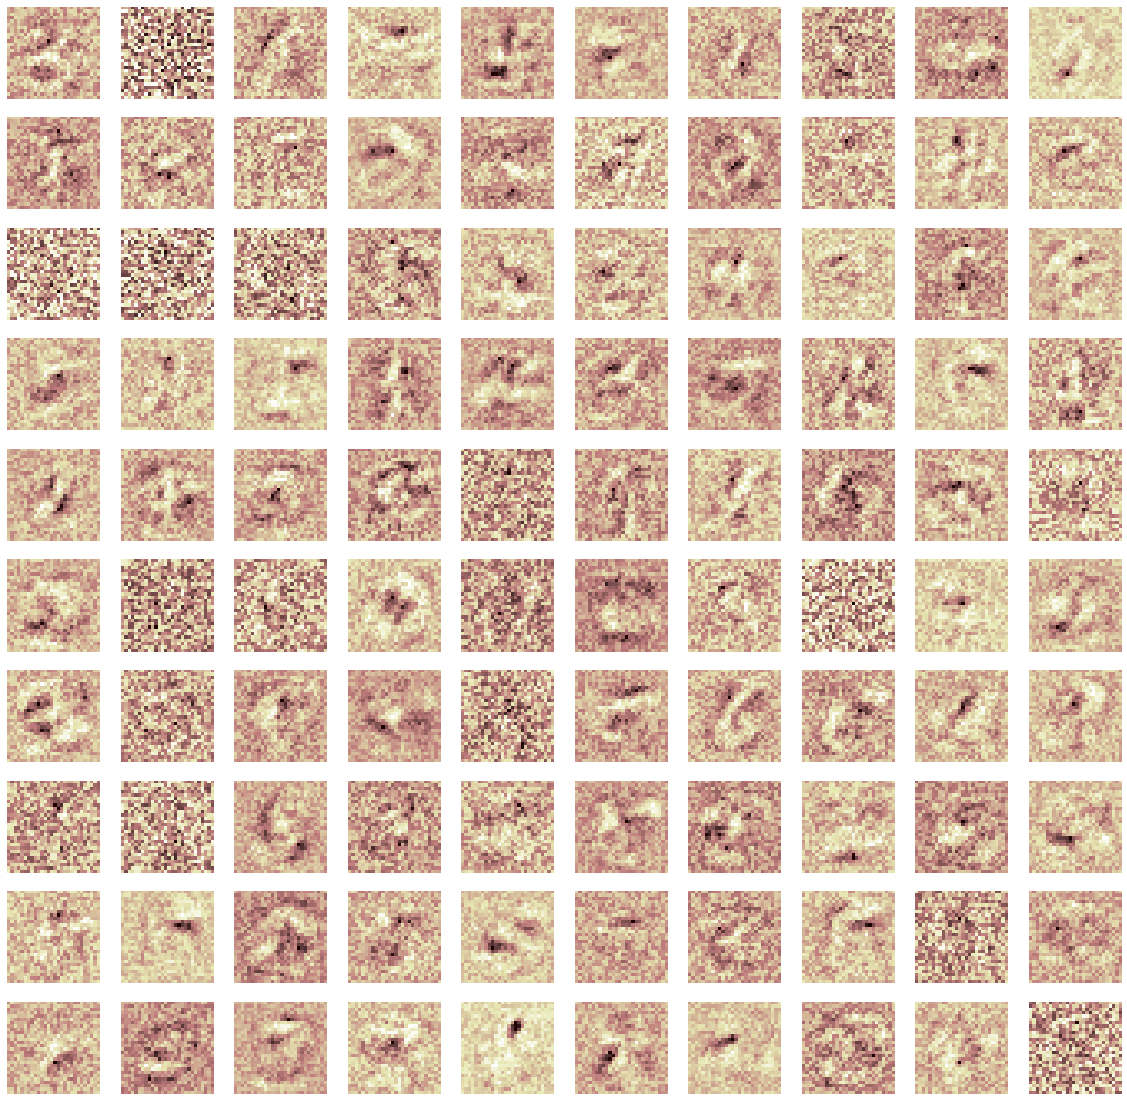

In [73]:
print(classifier.get_variable_names())

weights0 = classifier.get_variable_value("dnn/hiddenlayer_0/kernel")

print("weights0 shape:", weights0.shape)

num_nodes = weights0.shape[1]
num_rows = int(math.ceil(num_nodes / 10.0))
fig, axes = plt.subplots(num_rows, 10, figsize=(20, 2 * num_rows))
for coef, ax in zip(weights0.T, axes.ravel()):
    # Weights in coef is reshaped from 1x784 to 28x28.
    ax.matshow(coef.reshape(28, 28), cmap=plt.cm.pink)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()